In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import re

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hafez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hafez\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
sw = set(nltk.corpus.stopwords.words('english'))

def nltk_tag_pos(tag):   
    #adapted from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if tag[0]=='J':
        return wordnet.ADJ
    elif tag[0]=='V':
        return wordnet.VERB
    elif tag[0]=='N':
        return wordnet.NOUN
    elif tag[0]=='R':
        return wordnet.ADV
    else:          
        return wordnet.NOUN #noun is default lemmatize POS

def clean(text, stopwords):
    # remove tags like <tab>    
    text = re.sub(r'<[^<>]*>', ' ', text)  
    # split text on whitespace
    text_list = text.split()
    text_words = []
    wnetl = WordNetLemmatizer()
    punctuation = set(string.punctuation)
    
    # keep #tags and @mentions 
    ## punctuation.remove("#")
    ## punctuation.remove("@")

    text_POS = nltk.pos_tag(text_list)
#     print(text_POS)
    text_list = [wnetl.lemmatize(i[0],nltk_tag_pos(i[1])) for i in text_POS]
    
    for word in text_list:
        # remove punctuation marks at the beginning  
        # of each word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]
        
        # remove punctuation marks at the end of each word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]
        
        # a rule to eliminate most urls 
        if len(word) > 0 and "/" not in word:
            # eliminate stopwords 
            if word.lower() not in stopwords:
                # append the word to the text_words list
                text_words.append(word.lower())
        cleaner_text = " ".join(text_words)
    return cleaner_text

In [3]:
def ingest_and_clean_data():
    from pathlib import Path

    file_list_pos = [path for path in Path('imdb').rglob('*/pos/*.txt')]
    file_list_neg = [path for path in Path('imdb').rglob('*/neg/*.txt')]

    corpus_positive = [open(f, encoding="utf8").read() for f in file_list_pos]
    corpus_negative = [open(f, encoding="utf8").read() for f in file_list_neg]

    df = pd.DataFrame(corpus_positive, columns=['text'])
    df['sentiment'] = 'pos'

    df2 = pd.DataFrame(corpus_negative, columns=['text'])
    df2['sentiment'] = 'neg'

    df = df.append(df2)

    df['length'] = df.text.str.len()
    df = df[df.length >= 100]
    df.drop(['length'], axis=1, inplace=True)

    print(df.iloc[0])
    df.to_pickle('raw_reviews.pkl')
    df['text'] = df['text'].apply(clean, stopwords=sw)
    print(df.iloc[0])

    df.to_pickle('reviews.pkl')

In [4]:
# ingest_and_clean_data()

In [5]:
df2 = pd.read_pickle('raw_reviews.pkl').reset_index(drop=True)
df2.head()

,text,sentiment
0,I went and saw this movie last night after bei...,pos
1,Actor turned director Bill Paxton follows up h...,pos
2,As a recreational golfer with some knowledge o...,pos
3,"I saw this film in a sneak preview, and it is ...",pos
4,Bill Paxton has taken the true story of the 19...,pos


In [6]:
# df = pd.read_pickle('raw_reviews.pkl')
# df['text'] = df['text'].apply(clean, stopwords=sw)
# print(df.iloc[0])

# df.to_pickle('reviews.pkl')

In [7]:
df = pd.read_pickle('reviews.pkl').reset_index(drop=True)
# df['sentiment']=(df['sentiment']=='pos').astype(int)
df.head()

,text,sentiment
0,go saw movie last night coax friend mine i'll ...,pos
1,actor turn director bill paxton follow promisi...,pos
2,recreational golfer knowledge sport's history ...,pos
3,saw film sneak preview delightful cinematograp...,pos
4,bill paxton take true story 1913 us golf open ...,pos


In [8]:
print(df2.text[0])

I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


In [9]:
print(df.text[0])

go saw movie last night coax friend mine i'll admit reluctant see know ashton kutcher able comedy wrong kutcher play character jake fischer well kevin costner play ben randall professionalism sign good movie toy emotions one exactly entire theater sell overcome laughter first half movie move tear second half exit theater saw many woman tears many full grow men well try desperately let anyone see crying movie great suggest go see judge


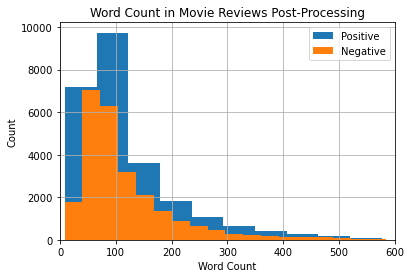

In [10]:
text = df.text.str.split()
df['word_count'] = [len(i) for i in text]

%matplotlib inline
fig, ax = plt.subplots()
ax= df[df.sentiment=='pos'].word_count.hist(bins=25)
ax = df[df.sentiment=='neg'].word_count.hist(bins=25)
ax.set_title('Word Count in Movie Reviews Post-Processing')
ax.set_xlabel('Word Count')
ax.set_ylabel('Count')
ax.legend(['Positive','Negative'])
plt.xlim([0, 600])
plt.show()

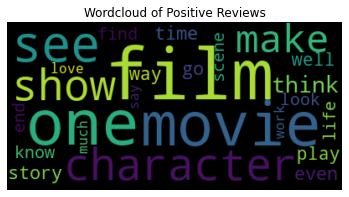

In [11]:
from wordcloud import WordCloud

text = ' '.join(df[df.sentiment=='pos'].text.str.split(' ').sum()).lower()
wordcloud = WordCloud(max_words=25).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud of Positive Reviews")
plt.show()

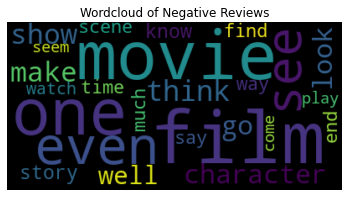

In [12]:
text = ' '.join(df[df.sentiment=='neg'].text.str.split(' ').sum()).lower()
wordcloud = WordCloud(max_words=25).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud of Negative Reviews")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=123)

Trying Multinomial Naive Bayes

The train set accuracy is 0.85839330506819


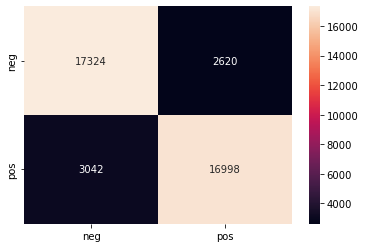

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

pipe_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', MultinomialNB())])

pipe_nb.fit(X_train, y_train)

nb_cv_acc_score = np.mean(cross_val_score(pipe_nb, X_train, y_train, scoring='accuracy'))

predicted_sentiment_train = cross_val_predict(pipe_nb,X_train,y_train)

cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


print(f"The train set accuracy is {nb_cv_acc_score}")

In [15]:
len(pipe_nb.steps[0][1].get_feature_names())

C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


87569

Trying Random Forest

The train set accuracy is 0.8490894815921154


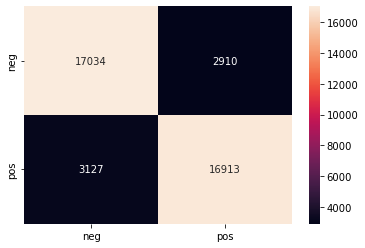

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', RandomForestClassifier(n_jobs=5))])
pipe_rf.fit(X_train, y_train)

rf_cv_acc_score = np.mean(cross_val_score(pipe_rf, X_train, y_train, scoring='accuracy'))
predicted_sentiment_train = cross_val_predict(pipe_rf,X_train,y_train)

cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

print(f"The train set accuracy is {rf_cv_acc_score}")

Trying XGBoost

The train set accuracy is 0.8490145691828032


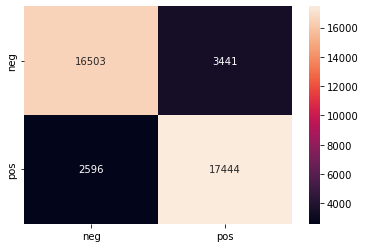

In [17]:
from xgboost import XGBClassifier
pipe_xgb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")),
                     ('clf', XGBClassifier(objective='binary:logistic', use_label_encoder=True,eval_metric='error',n_jobs=5))])

import warnings
warnings.filterwarnings("ignore") #ignore lot of xgb UserWarnings that don't affect results
pipe_xgb.fit(X_train, y_train)

xgb_cv_acc_score = np.mean(cross_val_score(pipe_xgb, X_train, y_train, scoring='accuracy'))
predicted_sentiment_train = cross_val_predict(pipe_xgb,X_train,y_train)
warnings.filterwarnings("default")

cm = confusion_matrix(y_train, predicted_sentiment_train)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

print(f"The train set accuracy is {xgb_cv_acc_score}")

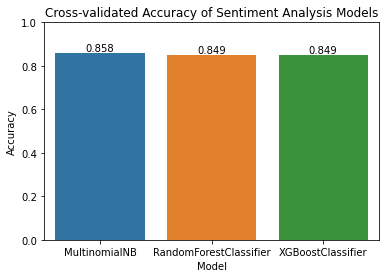

In [18]:
model_performance_df = pd.DataFrame({'Model':['MultinomialNB','RandomForestClassifier','XGBoostClassifier'],
                                     'Accuracy':[np.round(nb_cv_acc_score,3),np.round(rf_cv_acc_score,3),np.round(xgb_cv_acc_score,3)]})
g = sns.barplot(x='Model',y='Accuracy',data=model_performance_df)

g.bar_label(g.containers[0])
g.set_ylim(0,1)
g.set_title('Cross-validated Accuracy of Sentiment Analysis Models')
plt.show()

## After cross-validation on the Training set: 
Multinomial Naive Bayes had the best accuracy across the 5 cross-validation folds (approximately 85.6%).  

Hyperparameter Tuning Naive Bayes

In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'tfidf__min_df': (0, 0.1, 0.25),
    'tfidf__max_df': (0.5, 0.75, 1),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (1, 1e-2, 1e-3)
}

grid_search = GridSearchCV(pipe_nb, parameters, cv=5,n_jobs=5)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)
predicted_sentiment_train = grid_search.predict(X_train)

C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer =

The train set accuracy is 0.9821428571428571

The test set accuracy is 0.8793517406962785


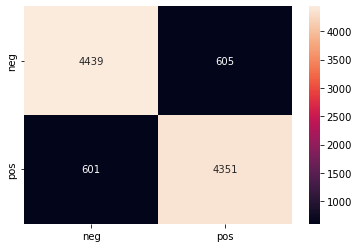


Best Parameters: {'clf__alpha': 1, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0, 'tfidf__ngram_range': (1, 2)}
The train set accuracy is 0.9821428571428571


In [20]:
from sklearn.metrics import accuracy_score
print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"\nThe test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
plt.show()
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")

In [21]:
from sklearn.model_selection import learning_curve
train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_,df.text, df.sentiment,scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores,axis=1)


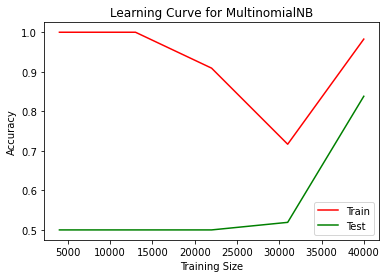

In [22]:
plt.plot(train_size, train_scores_mean, 'r-')
plt.plot(train_size, test_scores_mean, 'g-')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for MultinomialNB')
plt.legend(['Train','Test'])
plt.show()